Preparation

In [1]:
import MDAnalysis as mda
import prolif as plf
import warnings

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

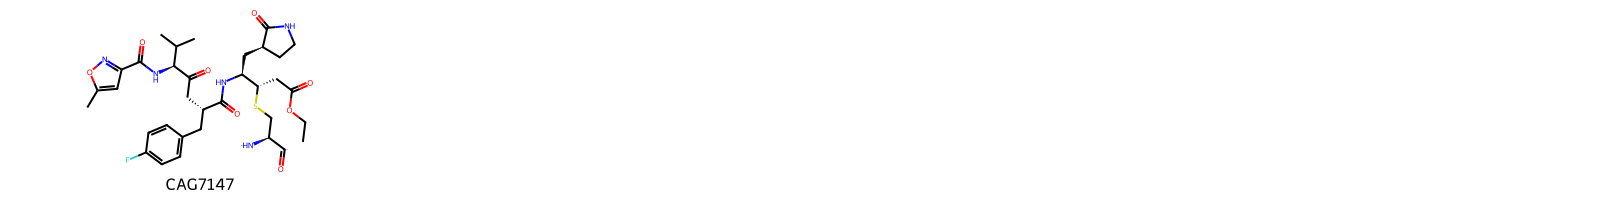

In [4]:
# Load topology and trajectory
u = mda.Universe("HRV2.pdb", "md_Cov2_center.xtc")

# Create selections for the ligand and protein
ligand_selection = u.select_atoms("resname CAG7")
protein_selection = u.select_atoms("protein")
ligand_selection.guess_bonds()
protein_selection.guess_bonds()

# Create a molecule from the MDAnalysis selection
ligand_mol = plf.Molecule.from_mda(ligand_selection)

# Display the molecule
plf.display_residues(ligand_mol, size=(400, 200))

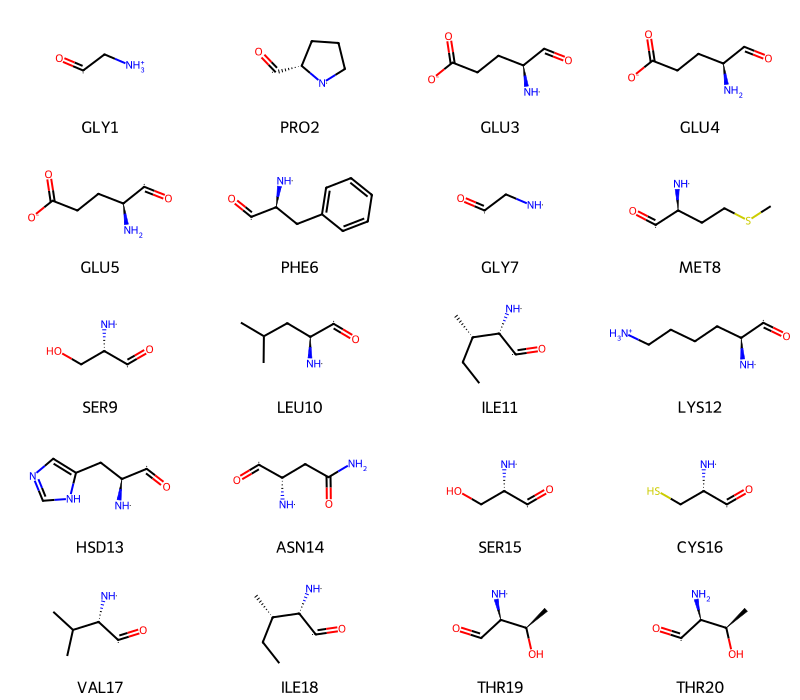

In [5]:
# Protein's residues
protein_mol = plf.Molecule.from_mda(protein_selection)

# remove the `slice(20)` part to show all residues
plf.display_residues(protein_mol, slice(20))

Fingerprint Generation

In [ ]:
# See the available fingerprints list
plf.Fingerprint.list_available()

In [ ]:
# Use default interactions
fp = plf.Fingerprint(vicinity_cutoff=5.0, count=True)
# Run on a slice of the trajectory frames: from begining to end with a step of 10
fp.run(u.trajectory, ligand_selection, protein_selection)

  0%|          | 0/15001 [00:00<?, ?it/s]

In [ ]:
# Fingerprints saving 
fp.to_pickle("fingerprint_HRV2.pkl")
fp = plf.Fingerprint.from_pickle("fingerprint_HRV2.pkl")

In [ ]:
# Print available frame numbers and residue pairs
for frame, interactions in fp.ifp.items():
    print(f"Frame: {frame}")
    for residue_pair in interactions.keys():
        print(f"  {residue_pair}")

In [ ]:
frame_number = 5000
if frame_number not in fp.ifp:
    print(f"Frame {frame_number} not found in the IFP dictionary.")
else:
    print(f"Frame {frame_number} found in the IFP dictionary.")

Analysis

In [ ]:
# Checking for a specific interaction

frame_number = 5000
ligand_residue = "UNK210.B"
protein_residue = "CYS194.A"

try:
    interaction_data = fp.ifp[frame_number][(ligand_residue, protein_residue)]
    print(f"Interaction data for frame {frame_number} and residues ({ligand_residue}, {protein_residue}):")
    print(interaction_data)
except KeyError as e:
    print(f"KeyError: {e}")
    print(f"No data found for frame {frame_number} and residues ({ligand_residue}, {protein_residue})")

In [ ]:
# ========== Fingerprints to DataFrame ==========

df = fp.to_dataframe()

# Convert to CSV format and save 
df.to_csv('Prolif_HRV2.csv', index=False)

# show only the 10 first frames
df.head(10)

In [ ]:
# Checking specific interactions

df.xs("TYR137.A", level="protein", axis=1).head(5)

In [ ]:
# ========== Tanimoto Similarity Calculation ==========

import pandas as pd
from rdkit import DataStructs

# Convert the fingerprints to bitvectors
bitvectors = fp.to_bitvectors()

# Calculate Tanimoto similarity between the first frame and the rest
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors)

# Convert the Tanimoto similarity results to a DataFrame
frame_numbers = range(len(tanimoto_sims))
df_tanimoto = pd.DataFrame({'Frame': frame_numbers, 'Tanimoto_Similarity': tanimoto_sims})

# Drop the index
df_tanimoto = df_tanimoto.reset_index(drop=True)

# Convert to CSV format and save 
df_tanimoto.to_csv('tanimoto_similarities_HRV2.csv', index=False)

# Display the DataFrame without the index
print(df_tanimoto.to_string(index=False))

In [ ]:
# 10 residues most frequently interacting with the ligand
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("%")
    .T
    * 100
)

In [ ]:
# percentage of the trajectory where each interaction type is present
(
    df.T.groupby(level="interaction")
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

Visualization

In [ ]:
# %matplotlib ipympl

fp.plot_barcode();

In [ ]:
fp.plot_lignetwork(ligand_mol)